# Python solving with LeNet


In this example, we'll explore learning with Caffe in Python, using the fully-exposed `Solver` interface.

In [1]:
import os
os.chdir('..')
print os.path.realpath(os.getcwd())
# print os.path.abspath(__file__)

/home/tzx/dev/caffe-rc3


In [2]:
import sys
sys.path.insert(0, './python')
print sys.path
# 其实可以在自己的 .bashrc 里加上 export PYTHONPATH=~/dev/caffe-rc/python:$PYTHONPATH，两种方法是一样的
import caffe

from pylab import *
%matplotlib inline

['./python', '', '/usr/local/lib/python2.7/dist-packages/percol-0.2.1-py2.7.egg', '/usr/local/lib/python2.7/dist-packages/cmigemo-0.1.6-py2.7.egg', '/home/tzx/dev/caffe-rc3/python', '/home/tzx/dev/caffe-rc3/examples', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/lib/pymodules/python2.7', '/usr/lib/python2.7/dist-packages/ubuntu-sso-client', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/tzx/.ipython']


We'll be running the provided LeNet example (make sure you've downloaded the data and created the databases, as below).

In [8]:
# Download and prepare data

# 不使用原来的脚本来获取数据，因为下载太慢了！我更喜欢用【迅雷】来下载
# !data/mnist/get_mnist.sh
# Instead，直接从 $DATASETS_DIR 拷贝过来就可以，用我们修改过的脚本：
!data/mnist/get_mnist_cvrs.sh 
!examples/mnist/create_mnist.sh

Copying from /home/tzx/datasets/datasets...
Unzipping...
Done.
Creating lmdb...
Done.


In [9]:
!cat data/mnist/get_mnist.sh
print "\n\n"
!cat data/mnist/get_mnist_cvrs.sh

#!/usr/bin/env sh
# This scripts downloads the mnist data and unzips it.

DIR="$( cd "$(dirname "$0")" ; pwd -P )"
cd $DIR

echo "Downloading..."

wget --no-check-certificate http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
wget --no-check-certificate http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
wget --no-check-certificate http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
wget --no-check-certificate http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

echo "Unzipping..."

gunzip train-images-idx3-ubyte.gz
gunzip train-labels-idx1-ubyte.gz
gunzip t10k-images-idx3-ubyte.gz
gunzip t10k-labels-idx1-ubyte.gz

# Creation is split out because leveldb sometimes causes segfault
# and needs to be re-created.

echo "Done."



#!/usr/bin/env sh
# This scripts downloads the mnist data and unzips it.

DIR="$( cd "$(dirname "$0")" ; pwd -P )"
cd $DIR

echo "Copying from $DATASETS_DIR..."

cp $DATASETS_DIR/MNIST/train-images-idx3-ubyte.gz ./
cp $DATASETS_DIR/M

We need two external files to help out:
* the net prototxt, defining the architecture and pointing to the train/test data
* the solver prototxt, defining the learning parameters

We start with the net. We'll write the net in a succinct and natural way as Python code that serializes to Caffe's protobuf model format.

This network expects to read from pregenerated LMDBs, but reading directly from `ndarray`s is also possible using `MemoryDataLayer`.

In [21]:
from caffe import layers as L
from caffe import params as P

def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.ip1 = L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    n.ip2 = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss = L.SoftmaxWithLoss(n.ip2, n.label)
    return n.to_proto()

print "begin"

with open('examples/mnist/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('examples/mnist/mnist_train_lmdb', 64)))

print "half"    
    
with open('examples/mnist/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('examples/mnist/mnist_test_lmdb', 100)))

print "done"

begin
half
done


The net has been written to disk in more verbose but human-readable serialization format using Google's protobuf library. You can read, write, and modify this description directly. Let's take a look at the train net.

In [6]:
!cat examples/mnist/lenet_auto_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  data_param {
    source: "examples/mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "ip1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "ip1"
  inner_product_param {
  

Now let's see the learning parameters, which are also written as a `prototxt` file. We're using SGD with momentum, weight decay, and a specific learning rate schedule.

In [7]:
!cat examples/mnist/lenet_auto_solver.prototxt

# The train/test net protocol buffer definition
train_net: "examples/mnist/lenet_auto_train.prototxt"
test_net: "examples/mnist/lenet_auto_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "examples/mnist/lenet"


Let's pick a device and load the solver. We'll use SGD (with momentum), but Adagrad and Nesterov's accelerated gradient are also available.

In [10]:
caffe.set_device(0)
caffe.set_mode_gpu()
solver = caffe.SGDSolver('examples/mnist/lenet_auto_solver.prototxt')

To get an idea of the architecture of our net, we can check the dimensions of the intermediate features (blobs) and parameters (these will also be useful to refer to when manipulating data later).

In [11]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('ip1', (64, 500)),
 ('ip2', (64, 10)),
 ('loss', ())]

In [12]:
# just print the weight sizes (not biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('ip1', (500, 800)),
 ('ip2', (10, 500))]

Before taking off, let's check that everything is loaded as we expect. We'll run a forward pass on the train and test nets and check that they contain our data.

In [13]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(2.4986772537231445, dtype=float32)}

[ 5.  0.  4.  1.  9.  2.  1.  3.]


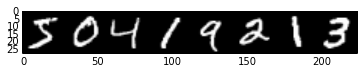

In [12]:
# we use a little trick to tile the first eight images
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray')
print solver.net.blobs['label'].data[:8]

[ 7.  2.  1.  0.  4.  1.  4.  9.]


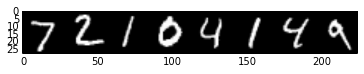

In [13]:
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray')
print solver.test_nets[0].blobs['label'].data[:8]

Both train and test nets seem to be loading data, and to have correct labels.

Let's take one step of (minibatch) SGD and see what happens.

In [14]:
solver.step(1)

Do we have gradients propagating through our filters? Let's see the updates to the first layer, shown here as a $4 \times 5$ grid of $5 \times 5$ filters.

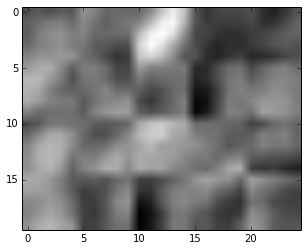

In [15]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray')

Something is happening. Let's run the net for a while, keeping track of a few things as it goes.
Note that this process will be the same as if training through the `caffe` binary. In particular:
* logging will continue to happen as normal
* snapshots will be taken at the interval specified in the solver prototxt (here, every 5000 iterations)
* testing will happen at the interval specified (here, every 500 iterations)

Since we have control of the loop in Python, we're free to compute additional things as we go, as we show below. We can do many other things as well, for example:
* write a custom stopping criterion
* change the solving process by updating the net in the loop

In [16]:
%%time
niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['ip2'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
CPU times: user 10.6 s, sys: 1.79 s, total: 12.4 s
Wall time: 10.8 s


Let's plot the train loss and test accuracy.

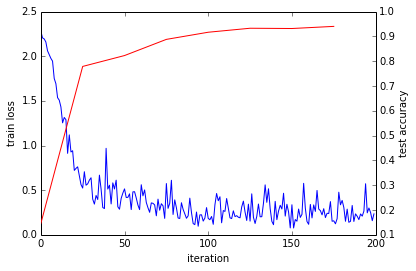

In [17]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')

The loss seems to have dropped quickly and coverged (except for stochasticity), while the accuracy rose correspondingly. Hooray!

Since we saved the results on the first test batch, we can watch how our prediction scores evolved. We'll plot time on the $x$ axis and each possible label on the $y$, with lightness indicating confidence.

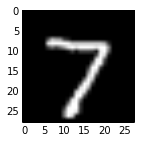

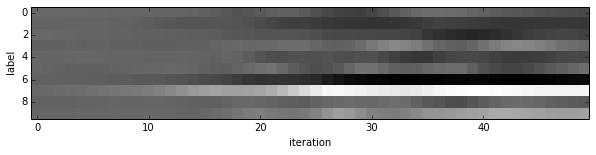

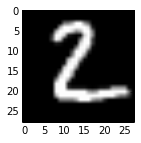

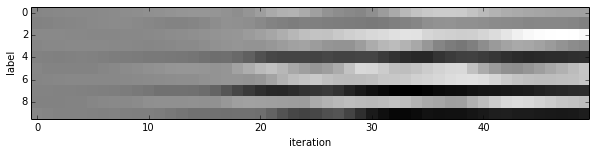

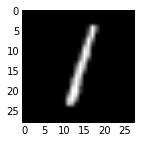

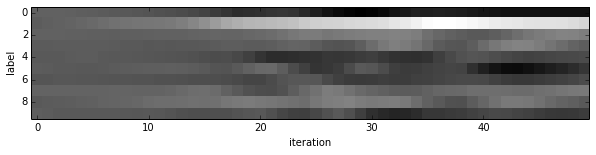

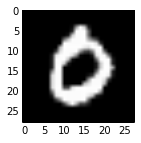

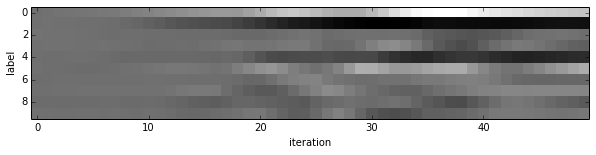

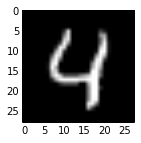

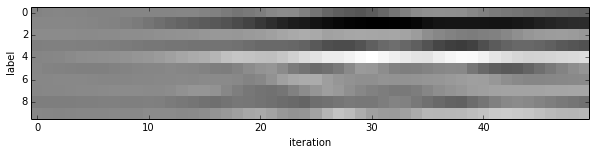

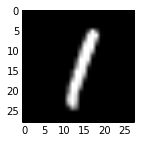

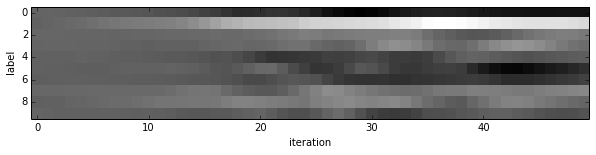

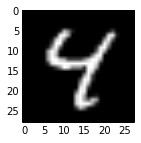

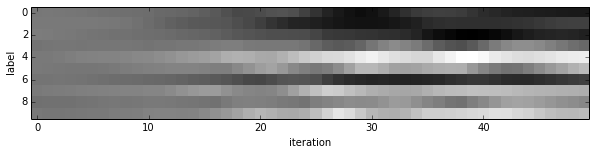

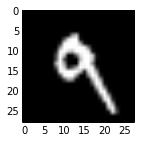

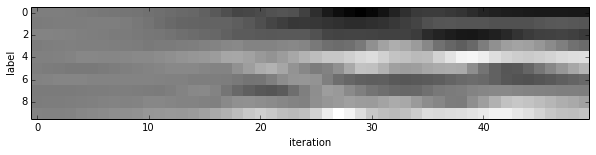

In [18]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

We started with little idea about any of these digits, and ended up with correct classifications for each. If you've been following along, you'll see the last digit is the most difficult, a slanted "9" that's (understandably) most confused with "4".

Note that these are the "raw" output scores rather than the softmax-computed probability vectors. The latter, shown below, make it easier to see the confidence of our net (but harder to see the scores for less likely digits).

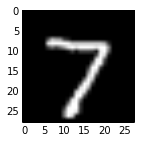

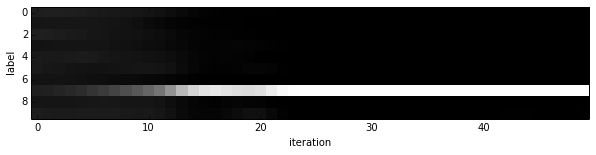

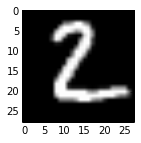

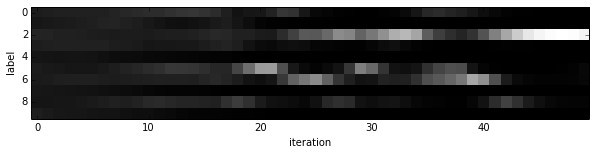

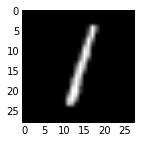

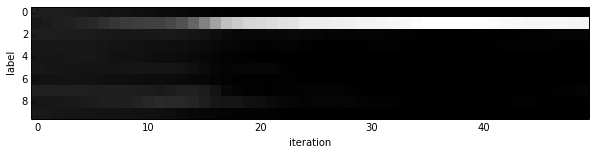

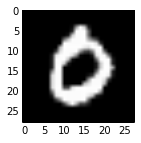

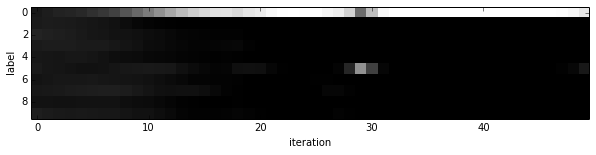

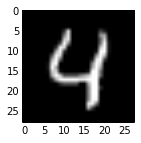

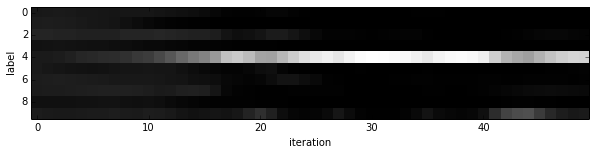

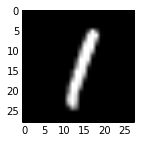

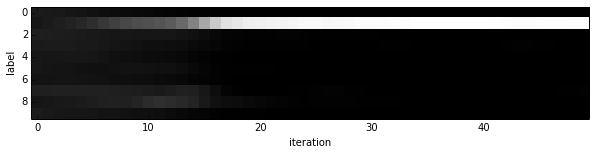

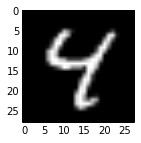

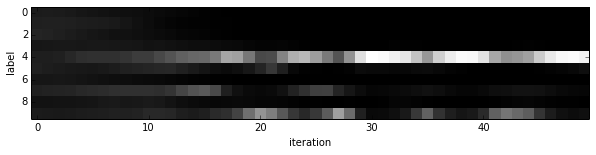

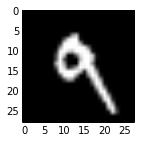

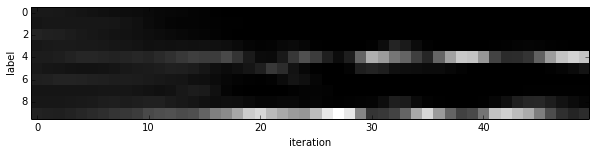

In [19]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(exp(output[:50, i].T) / exp(output[:50, i].T).sum(0), interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')